In [1]:
import os
import numpy as np
from keras import layers
from sklearn.model_selection import train_test_split
from keras.datasets import mnist, cifar10
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
def split_dataset(datapath, p):
    sample_folder_list = os.listdir(datapath) ##各个样本的文件夹
    sample_folder_list_dict = {} ##各个文件夹下的图片路径信息
    train_dir_dict = {} ##用作训练的样本路径集合
    test_dir_dict = {}##用作测试的样本路径集合

    for folder in sample_folder_list:
        sample_folder_list_dict[folder] = os.listdir(datapath+folder)
        train_dir_dict[folder] = random.sample(sample_folder_list_dict[folder], p)
        test_dir_dict[folder] = list(set(sample_folder_list_dict[folder])-set(train_dir_dict[folder]))

    train_label = []
    train_data = []

    test_label = []
    test_data = []

    for key in train_dir_dict:
        for path in train_dir_dict[key]:
            train_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            train_data.append(img)
        
        for path in test_dir_dict[key]:
            test_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            test_data.append(img)

    return train_data, train_label, test_data, test_label

In [17]:
import random
import cv2
datapath = '/root/zhb/Documents/PR/data/' 
train_data, train_label, test_data, test_label = split_dataset(datapath, 30)
train_data = np.asarray(train_data) 
train_label = np.asarray(train_label) 
test_data = np.asarray(test_data) 
test_label = np.asarray(test_label)
train_label = to_categorical(train_label, 38)
test_label = to_categorical(test_label, 38)

In [66]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32')
x_test = X_test.reshape(X_test.shape[0], 32, 32, 3).astype('float32')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_seed)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train_onehot = to_categorical(y_train, num_classes=None, dtype='float32')
print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 60000 images
Test Set Size = 10000 images


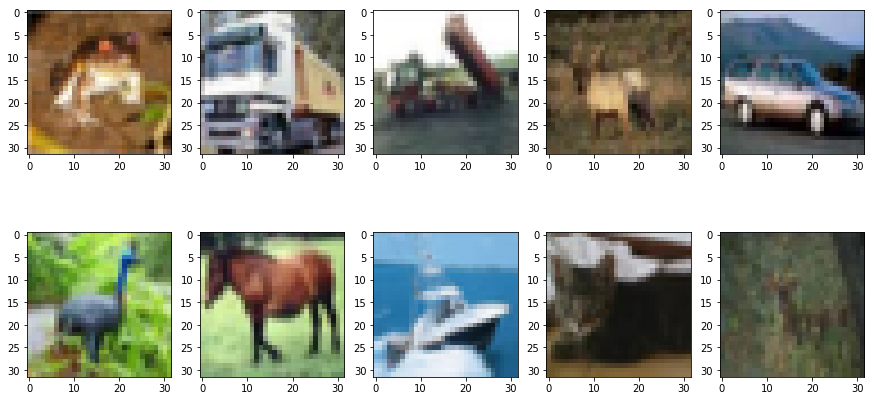

Labels : [[6]
 [9]
 [9]
 [4]
 [1]]
Labels : [[2]
 [7]
 [8]
 [3]
 [4]]


In [69]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [18]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    
#mnist
#     X_input = Input((28,28,1))

#cifar10
    X_input = Input((48,42,3))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    # X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(train_label.shape[1], activation='softmax', name='fc' + str(train_label.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [19]:
model = resNet()

In [20]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 42, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 54, 48, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 21, 64)   9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 21, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
nb_epoch = 500
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_resNet():
    
    history = LossHistory()
#     x_train & x_test reshaped because of single channel !
#     model.fit(train_data.reshape((-1,48,42,3)), train_label, batch_size=batch_size, epochs=nb_epoch,
#               validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    
    model.fit(train_data, train_label, epochs=nb_epoch, batch_size=batch_size,
                                            validation_data=(test_data, test_label),
                                            shuffle=True,
                                            callbacks=[history, early_stopping])

#     predictions = model.predict(x_test.reshape((-1,28,28,1)), verbose=0)
    return model, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [24]:
resnet_model, history = run_resNet()

Train on 1140 samples, validate on 1330 samples
Epoch 1/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.1990 - acc: 0.9807 - val_loss: 0.7256 - val_acc: 0.8376
Epoch 2/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.1809 - acc: 0.9842 - val_loss: 0.6763 - val_acc: 0.8594
Epoch 3/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.2308 - acc: 0.9772 - val_loss: 0.6437 - val_acc: 0.8722
Epoch 4/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.2135 - acc: 0.9728 - val_loss: 1.5190 - val_acc: 0.7489
Epoch 5/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.3994 - acc: 0.9114 - val_loss: 2.1881 - val_acc: 0.6842
Epoch 6/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.3246 - acc: 0.9325 - val_loss: 1.9761 - val_acc: 0.7090
Epoch 7/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.2972 - acc: 0.9474 - val_loss: 1.8451 - val_acc: 0.7008
Epoch 8

Epoch 61/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.0309 - acc: 0.9974 - val_loss: 0.5055 - val_acc: 0.9128
Epoch 62/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0445 - acc: 0.9965 - val_loss: 0.5034 - val_acc: 0.9143
Epoch 63/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0589 - acc: 0.9956 - val_loss: 0.5119 - val_acc: 0.9173
Epoch 64/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0435 - acc: 0.9974 - val_loss: 0.5135 - val_acc: 0.9165
Epoch 65/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0585 - acc: 0.9956 - val_loss: 0.5167 - val_acc: 0.9135
Epoch 66/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.0730 - acc: 0.9947 - val_loss: 0.5044 - val_acc: 0.9150
Epoch 67/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0576 - acc: 0.9965 - val_loss: 0.5035 - val_acc: 0.9143
Epoch 68/500
1140/1140 [========================

1140/1140 [==============================] - 2s 1ms/step - loss: 0.0433 - acc: 0.9974 - val_loss: 0.5920 - val_acc: 0.9090
Epoch 122/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0569 - acc: 0.9965 - val_loss: 0.5833 - val_acc: 0.9113
Epoch 123/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0428 - acc: 0.9974 - val_loss: 0.5809 - val_acc: 0.9105
Epoch 124/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0594 - acc: 0.9947 - val_loss: 0.5898 - val_acc: 0.9113
Epoch 125/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0601 - acc: 0.9947 - val_loss: 0.6660 - val_acc: 0.8940
Epoch 126/500
1140/1140 [==============================] - 2s 2ms/step - loss: 0.0604 - acc: 0.9947 - val_loss: 0.6948 - val_acc: 0.8940
Epoch 127/500
1140/1140 [==============================] - 2s 1ms/step - loss: 0.0768 - acc: 0.9939 - val_loss: 0.6944 - val_acc: 0.8940
Epoch 128/500
1140/1140 [==============================

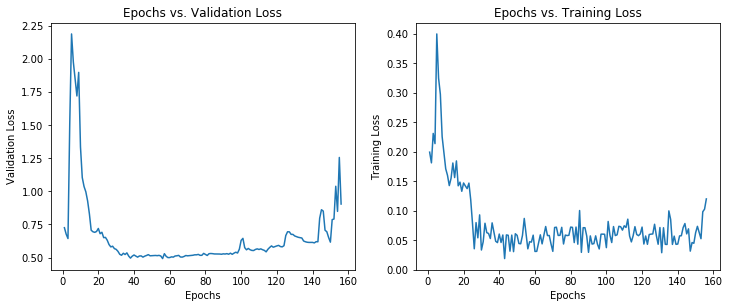

In [27]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,156+1), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,156+1), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

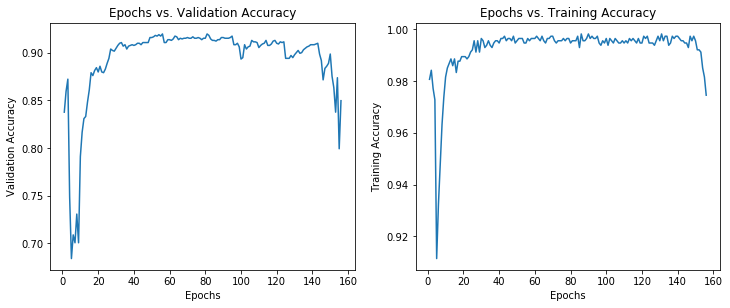

In [28]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,156+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,156+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

Test accuracy: 99.16 %


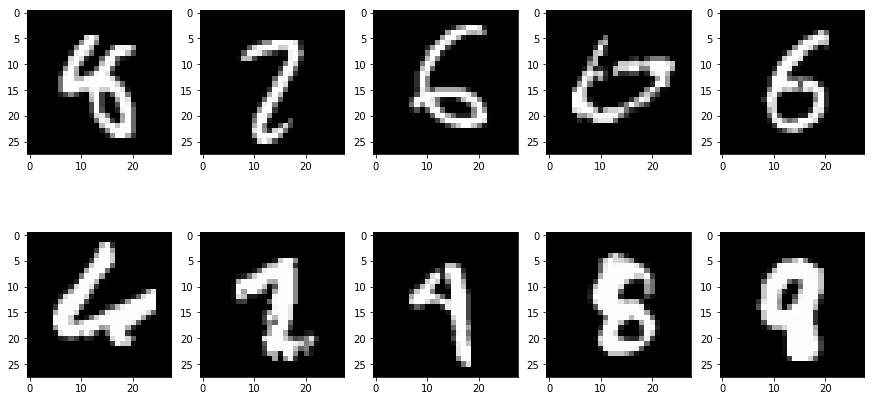

True:          [8 2 6 6 6]
classified as: [5 7 5 0 5]
True:          [6 2 4 8 8]
classified as: [4 1 9 5 9]


In [11]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))

In [9]:
resnet_model.save('resnet_mnist.h5')

In [21]:
predictions = model.predict(x_test.reshape((-1,28,28,1)), verbose=0)

ValueError: cannot reshape array of size 30720000 into shape (28,28,1)

In [3]:

model = load_model('resnet50_mnist.h5')

In [6]:
yFit = model.predict(x_test.reshape((-1,28,28,1)), batch_size=10, verbose=1)

10000/10000 [==============================] - 169s 17ms/step


In [7]:
accuracy = np.mean(np.argmax(yFit, axis=1) == y_test)
print(accuracy)

0.9877


In [51]:
np.argmax(yFit[0:10], axis=1)

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 9])

In [59]:
np.argmax(yFit, axis=1).shape

(10000,)

In [63]:
y_test=np.reshape(y_test, (10000, ))